In [1]:
import sys
from pathlib import Path

import torch
import pytorch_lightning as pl
import torch.nn as nn
import torchmetrics
from torch.utils.data import DataLoader, Dataset, random_split

In [2]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)
ENABLE_PROGRESS_BAR = 'google.colab' in sys.modules

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
class ApartmentDataset(Dataset):
    def __init__(self, features, labels):
        assert len(features) == len(labels)
        self._features = torch.from_numpy(features).float()
        self._labels = torch.from_numpy(labels).float()

    def __len__(self):
        return len(self._features)

    def __getitem__(self, idx):
        return self._features[idx], self._labels[idx]


class ApartmentDataModule(pl.LightningDataModule):
    def __init__(self, dataset: ApartmentDataset):
        super().__init__()
        self._dataset = dataset
        self._train_dataset = None
        self._val_dataset = None
        self._test_dataset = None

    def prepare_data(self):
        test_size = round(len(self._dataset) * 0.1)
        train_size = round((len(self._dataset) - test_size) * 0.85)
        self._test_dataset, rest = random_split(self._dataset, (test_size, len(self._dataset) - test_size), )
        self._train_dataset, self._val_dataset = random_split(rest, (train_size, len(rest) - train_size))

    def train_dataloader(self):
        return DataLoader(self._train_dataset, batch_size=512, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self._val_dataset, num_workers=12)

    def test_dataloader(self):
        return DataLoader(self._test_dataset, num_workers=12)


In [5]:
labels_to_names = {
    0: 'cheap',
    1: 'average',
    2: 'expensive'
}

In [6]:
import io

import torchvision
import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image
from torchmetrics.classification import MulticlassConfusionMatrix
from pytorch_lightning.loggers import TensorBoardLogger

In [7]:
import numpy as np
from typing import Callable
from torch.nn.modules.loss import _Loss


class ApartmentClassifier(pl.LightningModule):
    __act_t = Callable[[torch.Tensor], torch.Tensor]
    
    def __init__(
            self,
            input_size,
            output_size,
            *,
            activations: __act_t | list[__act_t] | None = None,
            loss: _Loss | None = None,
            batch_norm: bool = False
    ):
        super(ApartmentClassifier, self).__init__()

        self.l1 = nn.Linear(input_size, 512)
        self.l2 = nn.Linear(512, 512)
        self.l3 = nn.Linear(512, 256)
        self.l4 = nn.Linear(256, 128)
        self.l5 = nn.Linear(128, 32)
        self.l6 = nn.Linear(32, output_size)
        
        if isinstance(activations, Callable):
            for i in range(1, 6):
                setattr(self, f"act{i}", activations)
        elif isinstance(activations, list) and all(isinstance(a, Callable) for a in activations):
            assert len(activations) == 5
            for i, act in enumerate(activations, start=1):
                setattr(self, f"act{i}", act)
        else:
            assert not activations
            for i in range(1, 6):
                setattr(self, f"act{i}", torch.sigmoid)

        self._loss = loss or torch.nn.CrossEntropyLoss()
        
        for i, in_size in enumerate([512, 512, 256, 128, 32], start=1):
            setattr(self, f"bn{i}", nn.BatchNorm1d(in_size) if batch_norm else nn.Identity())

        self._accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=3).to(device)
        self._accuracy_per_class = torchmetrics.classification.MulticlassAccuracy(num_classes=3, average='none').to(
            device)

        # (predicted, actual)
        self._test_preds = None
        
        
        self.example_input_array = torch.rand((16, input_size)).to(device)

    def forward(self, x: torch.Tensor):

        x = self.l1(x)
        x = self.bn1(x)
        x = self.act1(x)
        
        x = self.l2(x)
        x = self.bn2(x)
        x = self.act2(x)
        
        x = self.l3(x)
        x = self.bn3(x)
        x = self.act3(x)
        
        x = self.l4(x)
        x = self.bn4(x)
        x = self.act4(x)
        
        x = self.l5(x)
        x = self.bn5(x)
        x = self.act5(x)
        
        x = self.l6(x)
        
        return x.float()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

    def loss(self, logits, labels):
        return self._loss(logits, labels)

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.loss(logits, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.loss(logits, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss

    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        label = torch.argmax(y, dim=1)
        logits = self.forward(x)
        predicted = torch.argmax(logits, dim=1)

        loss = self.loss(logits, y)
        self.log('test_loss', loss, on_step=False, on_epoch=True)

        acc = self._accuracy(predicted, label)
        self.log('test_mean_acc', acc, on_step=False, on_epoch=True)
        acc_per_class = self._accuracy_per_class(predicted, label)
        self.log(f'test_acc_{label[0]}', acc_per_class[int(label[0])], on_step=False, on_epoch=True)

        self._test_preds.append((predicted, label))

    def on_test_start(self) -> None:
        self._test_preds = []

    def on_test_epoch_end(self) -> None:        
        preds = torch.cat([p for p, _ in self._test_preds])
        labels = torch.cat([l for _, l in self._test_preds])
        confusion = MulticlassConfusionMatrix(num_classes=3, normalize='true').to(device)
        computed_confusion = confusion(preds, labels)
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.heatmap(computed_confusion.cpu().numpy(), annot=True, annot_kws={"size": 16}, ax=ax)
        buf = io.BytesIO()
        plt.savefig(buf, format='jpeg', bbox_inches='tight')
        buf.seek(0)
        im = Image.open(buf)
        im = torchvision.transforms.ToTensor()(im)
        logger = self.logger
        assert isinstance(logger, TensorBoardLogger)
        logger.experiment.add_image("test_confusion_matrix", im)
        
        self.log('test_mean_acc_unweighted', np.diagonal(computed_confusion.cpu().numpy()).sum() / 3)
        
        logger.experiment.add_graph(self, self.example_input_array)


In [8]:
import pandas as pd

In [9]:
TRAIN_DATA = Path('data/train_data.csv')

_df = pd.read_csv(TRAIN_DATA)
_df

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,570796,2007,1928,24,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0
4120,307079,2015,644,22,terraced,individual_heating,management_in_trust,102.0,400.0,0~5min,5min~10min,5.0,10.0,Daegu,7,7.0,11.0
4121,357522,2007,868,20,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0
4122,312389,1978,1327,1,corridor,individual_heating,self_management,87.0,0.0,0~5min,0-5min,1.0,4.0,Kyungbuk_uni_hospital,3,7.0,11.0


In [10]:
def price_to_class(price: int) -> int:
    return int(price > 350_000) + int(price > 100_000)


labels = pd.get_dummies(_df['SalePrice'].rename('class').apply(price_to_class))
labels

,0,1,2
0,False,True,False
1,True,False,False
2,True,False,False
3,False,False,True
4,True,False,False
...,...,...,...
4119,False,False,True
4120,False,True,False
4121,False,False,True
4122,False,True,False


In [11]:
categorical_cols = [
    'HallwayType',
    'HeatingType',
    'AptManageType',
    'TimeToBusStop',
    'TimeToSubway',
    'SubwayStation',
]

_df = _df.drop(columns=['SalePrice'])

def create_scaler_pair(df) -> tuple[Callable, Callable]:
    df = df.sort_index(axis=1)
    _df_num = df.select_dtypes(include='number')
    
    scale_min = _df_num.min()
    scale_max = _df_num.max()
    
    def scale(df: pd.DataFrame) -> pd.DataFrame:
        df_num = df.select_dtypes(include='number')
        df_cat = df.select_dtypes(exclude='number')
        
        df_num_norm = (df_num - scale_min) / (scale_max - scale_min)
        
        return pd.concat([df_num_norm, df_cat], axis=1).sort_index(axis=1)
    
    def inverse_scale(df_norm: pd.DataFrame) -> pd.DataFrame:
        df_num = df_norm.select_dtypes(include='number')
        df_cat = df_norm.select_dtypes(exclude='number')
        
        df_num_denorm = df_num * (scale_max - scale_min) + scale_min
        
        return pd.concat([df_num_denorm, df_cat], axis=1).sort_index(axis=1)
    
    return scale, inverse_scale

scale, inverse_scale = create_scaler_pair(_df)

_df_scaled = scale(_df)
_df_scaled

,AptManageType,Floor,HallwayType,HeatingType,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_Parkinglot(Basement),N_Parkinglot(Ground),N_SchoolNearBy(Total),N_elevators,N_manager,Size(sqf),SubwayStation,TimeToBusStop,TimeToSubway,YearBuilt
0,management_in_trust,0.047619,terraced,individual_heating,0.444444,0.3750,0.139288,0.155680,0.529412,0.000000,0.153846,0.308356,Kyungbuk_uni_hospital,5min~10min,10min~15min,0.756757
1,self_management,0.166667,corridor,individual_heating,0.222222,0.7500,0.057532,0.112202,0.235294,0.074074,0.076923,0.205268,Daegu,0~5min,5min~10min,0.189189
2,self_management,0.119048,corridor,individual_heating,0.222222,0.7500,0.057532,0.112202,0.235294,0.074074,0.076923,0.205268,Daegu,0~5min,5min~10min,0.189189
3,management_in_trust,0.166667,terraced,individual_heating,0.444444,0.1875,0.405753,0.349229,0.411765,0.407407,0.307692,0.872389,Sin-nam,0~5min,0-5min,0.756757
4,self_management,0.023810,mixed,individual_heating,0.222222,0.5625,0.059803,0.199158,0.823529,0.296296,0.230769,0.231153,Myung-duk,5min~10min,15min~20min,0.378378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,management_in_trust,0.547619,terraced,individual_heating,1.000000,0.5625,0.961393,0.000000,0.588235,0.592593,1.000000,0.814260,Kyungbuk_uni_hospital,0~5min,0-5min,0.783784
4120,management_in_trust,0.500000,terraced,individual_heating,0.666667,0.4375,0.302801,0.143058,0.647059,0.370370,0.307692,0.231153,Daegu,0~5min,5min~10min,1.000000
4121,management_in_trust,0.452381,terraced,individual_heating,1.000000,0.5625,0.961393,0.000000,0.588235,0.592593,1.000000,0.332879,Kyungbuk_uni_hospital,0~5min,0-5min,0.783784
4122,self_management,0.000000,corridor,individual_heating,0.222222,0.4375,0.000000,0.122020,0.647059,0.148148,0.000000,0.541326,Kyungbuk_uni_hospital,0~5min,0-5min,0.000000


In [12]:
from IPython.display import display

# sanity check
display(_df.sort_index(axis=1))
display(inverse_scale(_df_scaled))

,AptManageType,Floor,HallwayType,HeatingType,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_Parkinglot(Basement),N_Parkinglot(Ground),N_SchoolNearBy(Total),N_elevators,N_manager,Size(sqf),SubwayStation,TimeToBusStop,TimeToSubway,YearBuilt
0,management_in_trust,3,terraced,individual_heating,5,6.0,184.0,111.0,9.0,0.0,3.0,814,Kyungbuk_uni_hospital,5min~10min,10min~15min,2006
1,self_management,8,corridor,individual_heating,3,12.0,76.0,80.0,4.0,2.0,2.0,587,Daegu,0~5min,5min~10min,1985
2,self_management,6,corridor,individual_heating,3,12.0,76.0,80.0,4.0,2.0,2.0,587,Daegu,0~5min,5min~10min,1985
3,management_in_trust,8,terraced,individual_heating,5,3.0,536.0,249.0,7.0,11.0,5.0,2056,Sin-nam,0~5min,0-5min,2006
4,self_management,2,mixed,individual_heating,3,9.0,79.0,142.0,14.0,8.0,4.0,644,Myung-duk,5min~10min,15min~20min,1992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,management_in_trust,24,terraced,individual_heating,10,9.0,1270.0,0.0,10.0,16.0,14.0,1928,Kyungbuk_uni_hospital,0~5min,0-5min,2007
4120,management_in_trust,22,terraced,individual_heating,7,7.0,400.0,102.0,11.0,10.0,5.0,644,Daegu,0~5min,5min~10min,2015
4121,management_in_trust,20,terraced,individual_heating,10,9.0,1270.0,0.0,10.0,16.0,14.0,868,Kyungbuk_uni_hospital,0~5min,0-5min,2007
4122,self_management,1,corridor,individual_heating,3,7.0,0.0,87.0,11.0,4.0,1.0,1327,Kyungbuk_uni_hospital,0~5min,0-5min,1978


,AptManageType,Floor,HallwayType,HeatingType,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_Parkinglot(Basement),N_Parkinglot(Ground),N_SchoolNearBy(Total),N_elevators,N_manager,Size(sqf),SubwayStation,TimeToBusStop,TimeToSubway,YearBuilt
0,management_in_trust,3.0,terraced,individual_heating,5.0,6.0,184.0,111.0,9.0,0.0,3.0,814.0,Kyungbuk_uni_hospital,5min~10min,10min~15min,2006.0
1,self_management,8.0,corridor,individual_heating,3.0,12.0,76.0,80.0,4.0,2.0,2.0,587.0,Daegu,0~5min,5min~10min,1985.0
2,self_management,6.0,corridor,individual_heating,3.0,12.0,76.0,80.0,4.0,2.0,2.0,587.0,Daegu,0~5min,5min~10min,1985.0
3,management_in_trust,8.0,terraced,individual_heating,5.0,3.0,536.0,249.0,7.0,11.0,5.0,2056.0,Sin-nam,0~5min,0-5min,2006.0
4,self_management,2.0,mixed,individual_heating,3.0,9.0,79.0,142.0,14.0,8.0,4.0,644.0,Myung-duk,5min~10min,15min~20min,1992.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,management_in_trust,24.0,terraced,individual_heating,10.0,9.0,1270.0,0.0,10.0,16.0,14.0,1928.0,Kyungbuk_uni_hospital,0~5min,0-5min,2007.0
4120,management_in_trust,22.0,terraced,individual_heating,7.0,7.0,400.0,102.0,11.0,10.0,5.0,644.0,Daegu,0~5min,5min~10min,2015.0
4121,management_in_trust,20.0,terraced,individual_heating,10.0,9.0,1270.0,0.0,10.0,16.0,14.0,868.0,Kyungbuk_uni_hospital,0~5min,0-5min,2007.0
4122,self_management,1.0,corridor,individual_heating,3.0,7.0,0.0,87.0,11.0,4.0,1.0,1327.0,Kyungbuk_uni_hospital,0~5min,0-5min,1978.0


In [13]:
df = pd.concat([_df_scaled.drop(columns=categorical_cols),
                *[pd.get_dummies(_df_scaled[col], prefix=col, dtype=int) for col in categorical_cols]], axis=1)
df

,Floor,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_Parkinglot(Basement),N_Parkinglot(Ground),N_SchoolNearBy(Total),N_elevators,N_manager,Size(sqf),YearBuilt,...,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,0.047619,0.444444,0.3750,0.139288,0.155680,0.529412,0.000000,0.153846,0.308356,0.756757,...,0,0,0,0,0,0,1,0,0,0
1,0.166667,0.222222,0.7500,0.057532,0.112202,0.235294,0.074074,0.076923,0.205268,0.189189,...,1,0,0,0,0,1,0,0,0,0
2,0.119048,0.222222,0.7500,0.057532,0.112202,0.235294,0.074074,0.076923,0.205268,0.189189,...,1,0,0,0,0,1,0,0,0,0
3,0.166667,0.444444,0.1875,0.405753,0.349229,0.411765,0.407407,0.307692,0.872389,0.756757,...,0,0,0,0,0,0,0,0,1,0
4,0.023810,0.222222,0.5625,0.059803,0.199158,0.823529,0.296296,0.230769,0.231153,0.378378,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,0.547619,1.000000,0.5625,0.961393,0.000000,0.588235,0.592593,1.000000,0.814260,0.783784,...,0,0,0,0,0,0,1,0,0,0
4120,0.500000,0.666667,0.4375,0.302801,0.143058,0.647059,0.370370,0.307692,0.231153,1.000000,...,1,0,0,0,0,1,0,0,0,0
4121,0.452381,1.000000,0.5625,0.961393,0.000000,0.588235,0.592593,1.000000,0.332879,0.783784,...,0,0,0,0,0,0,1,0,0,0
4122,0.000000,0.222222,0.4375,0.000000,0.122020,0.647059,0.148148,0.000000,0.541326,0.000000,...,0,0,0,0,0,0,1,0,0,0


In [14]:
features = df
features

,Floor,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_Parkinglot(Basement),N_Parkinglot(Ground),N_SchoolNearBy(Total),N_elevators,N_manager,Size(sqf),YearBuilt,...,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,0.047619,0.444444,0.3750,0.139288,0.155680,0.529412,0.000000,0.153846,0.308356,0.756757,...,0,0,0,0,0,0,1,0,0,0
1,0.166667,0.222222,0.7500,0.057532,0.112202,0.235294,0.074074,0.076923,0.205268,0.189189,...,1,0,0,0,0,1,0,0,0,0
2,0.119048,0.222222,0.7500,0.057532,0.112202,0.235294,0.074074,0.076923,0.205268,0.189189,...,1,0,0,0,0,1,0,0,0,0
3,0.166667,0.444444,0.1875,0.405753,0.349229,0.411765,0.407407,0.307692,0.872389,0.756757,...,0,0,0,0,0,0,0,0,1,0
4,0.023810,0.222222,0.5625,0.059803,0.199158,0.823529,0.296296,0.230769,0.231153,0.378378,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,0.547619,1.000000,0.5625,0.961393,0.000000,0.588235,0.592593,1.000000,0.814260,0.783784,...,0,0,0,0,0,0,1,0,0,0
4120,0.500000,0.666667,0.4375,0.302801,0.143058,0.647059,0.370370,0.307692,0.231153,1.000000,...,1,0,0,0,0,1,0,0,0,0
4121,0.452381,1.000000,0.5625,0.961393,0.000000,0.588235,0.592593,1.000000,0.332879,0.783784,...,0,0,0,0,0,0,1,0,0,0
4122,0.000000,0.222222,0.4375,0.000000,0.122020,0.647059,0.148148,0.000000,0.541326,0.000000,...,0,0,0,0,0,0,1,0,0,0


In [15]:
dataset = ApartmentDataset(features=features.values, labels=labels.values)
data_module = ApartmentDataModule(dataset=dataset)

### 1. Entropia krzyżowa (uśredniona po próbkach), aktywacja sigmoid

In [16]:
sigmoid_centropy_mean_model = ApartmentClassifier(input_size=len(features.columns), output_size=3, loss=torch.nn.CrossEntropyLoss(reduction='mean'))
logger = pl.loggers.TensorBoardLogger(
                save_dir='.',
                version='1_sigmoid_centropy_mean',
                name='lightning_logs',
                log_graph=True
            )
trainer = pl.Trainer(max_epochs=300, enable_progress_bar=ENABLE_PROGRESS_BAR, logger=logger)
trainer.fit(sigmoid_centropy_mean_model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/tomek/miniconda3/envs/ssne_p2/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory ./lightning_logs/1_sigmoid_centropy_mean/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type               | Params | In sizes  | Out sizes
------------------------------------------------------------------------------------
0  | l1                  | Linear             | 17.4 K | [16, 33]  | [16, 512]
1  | l2                  | Linear             | 262 K  | [16, 512] | [16, 512]
2  | l3                  | Linear             | 131 K  | [16, 512] | [16, 256]
3  | l4                  | Linear             | 32.9 K | [16, 256] | [16, 128]
4  | l5           

/home/tomek/miniconda3/envs/ssne_p2/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:189: UserWarning: .test(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_acc_0         │            0.0            │
│        test_acc_1         │            1.0            │
│        test_acc_2         │            0.0            │
│         test_loss         │    0.8091863393783569     │
│       test_mean_acc       │    0.7063106894493103     │
│ test_mean_acc_unweighted  │    0.3333333333333333     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.8091863393783569,
  'test_mean_acc': 0.7063106894493103,
  'test_acc_1': 1.0,
  'test_acc_2': 0.0,
  'test_acc_0': 0.0,
  'test_mean_acc_unweighted': 0.3333333333333333}]

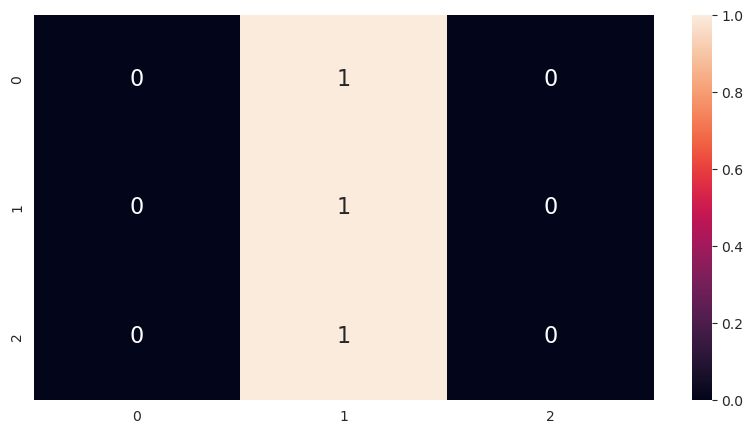

In [17]:
trainer.test(datamodule=data_module, ckpt_path='last')

### 2. Ważona entropia krzyżowa (uśredniona po próbkach), aktywacja sigmoid

In [18]:
sigmoid_centropy_weighted_mean_model = ApartmentClassifier(input_size=len(features.columns), output_size=3, loss=torch.nn.CrossEntropyLoss(
            weight=torch.FloatTensor([3, 1, 3]).cuda(), reduction='mean'
        ))
logger = pl.loggers.TensorBoardLogger(
                save_dir='.',
                version='2_sigmoid_centropy_weighted_mean',
                name='lightning_logs',
                log_graph=True
            )
trainer = pl.Trainer(max_epochs=300, enable_progress_bar=ENABLE_PROGRESS_BAR, logger=logger)
trainer.fit(sigmoid_centropy_weighted_mean_model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/tomek/miniconda3/envs/ssne_p2/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory ./lightning_logs/2_sigmoid_centropy_weighted_mean/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type               | Params | In sizes  | Out sizes
------------------------------------------------------------------------------------
0  | l1                  | Linear             | 17.4 K | [16, 33]  | [16, 512]
1  | l2                  | Linear             | 262 K  | [16, 512] | [16, 512]
2  | l3                  | Linear             | 131 K  | [16, 512] | [16, 256]
3  | l4                  | Linear             | 32.9 K | [16, 256] | [16, 128]
4  | l5  

/home/tomek/miniconda3/envs/ssne_p2/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:189: UserWarning: .test(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_acc_0         │    0.9677419066429138     │
│        test_acc_1         │    0.8070175647735596     │
│        test_acc_2         │    0.8615384697914124     │
│         test_loss         │    0.5602167844772339     │
│       test_mean_acc       │    0.8398058414459229     │
│ test_mean_acc_unweighted  │    0.8787659804026285     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5602167844772339,
  'test_mean_acc': 0.8398058414459229,
  'test_acc_1': 0.8070175647735596,
  'test_acc_2': 0.8615384697914124,
  'test_acc_0': 0.9677419066429138,
  'test_mean_acc_unweighted': 0.8787659804026285}]

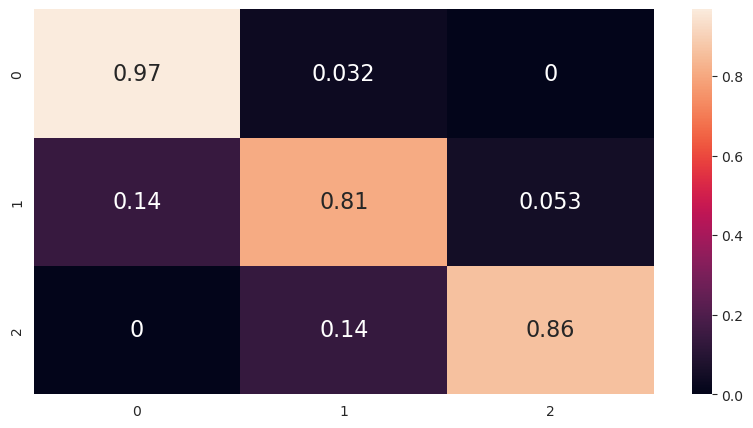

In [19]:
trainer.test(datamodule=data_module, ckpt_path='last')

### 3. Ważona entropia krzyżowa (sumowana po próbkach), aktywacja sigmoid


In [20]:
sigmoid_centropy_weighted_model = ApartmentClassifier(input_size=len(features.columns), output_size=3, loss=torch.nn.CrossEntropyLoss(weight=torch.Tensor([3, 1, 2.1]), reduction='sum'))
logger = pl.loggers.TensorBoardLogger(
                save_dir='.',
                version='3_sigmoid_centropy_weighted_model',
                name='lightning_logs',
                log_graph=True
            )
trainer = pl.Trainer(max_epochs=300, enable_progress_bar=ENABLE_PROGRESS_BAR, logger=logger)
trainer.fit(sigmoid_centropy_weighted_model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/tomek/miniconda3/envs/ssne_p2/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory ./lightning_logs/3_sigmoid_centropy_weighted_model/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type               | Params | In sizes  | Out sizes
------------------------------------------------------------------------------------
0  | l1                  | Linear             | 17.4 K | [16, 33]  | [16, 512]
1  | l2                  | Linear             | 262 K  | [16, 512] | [16, 512]
2  | l3                  | Linear             | 131 K  | [16, 512] | [16, 256]
3  | l4                  | Linear             | 32.9 K | [16, 256] | [16, 128]
4  | l5 

/home/tomek/miniconda3/envs/ssne_p2/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:189: UserWarning: .test(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_acc_0         │            1.0            │
│        test_acc_1         │    0.7935484051704407     │
│        test_acc_2         │    0.7169811129570007     │
│         test_loss         │    0.5855086445808411     │
│       test_mean_acc       │    0.8082524538040161     │
│ test_mean_acc_unweighted  │    0.8368431727091471     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5855086445808411,
  'test_mean_acc': 0.8082524538040161,
  'test_acc_0': 1.0,
  'test_acc_1': 0.7935484051704407,
  'test_acc_2': 0.7169811129570007,
  'test_mean_acc_unweighted': 0.8368431727091471}]

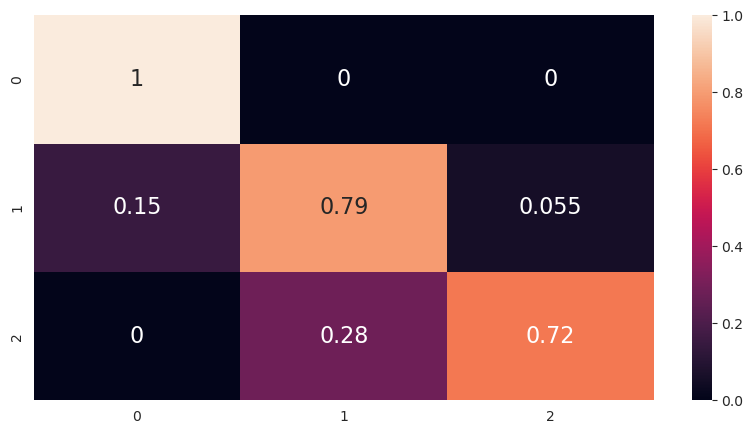

In [21]:
trainer.test(datamodule=data_module, ckpt_path='last')

### 4. Ważona entropia krzyżowa, aktywacja ReLU

In [22]:
relu_centropy_weighted_model = ApartmentClassifier(input_size=len(features.columns), output_size=3, loss=torch.nn.CrossEntropyLoss(weight=torch.Tensor([2.5, 1.1, 2.2]), reduction='sum'), activations=nn.functional.relu)
logger = pl.loggers.TensorBoardLogger(
                save_dir='.',
                version='4_relu_centropy_weighted_model',
                name='lightning_logs',
                log_graph=True
            )
trainer = pl.Trainer(max_epochs=300, enable_progress_bar=ENABLE_PROGRESS_BAR, logger=logger)
trainer.fit(relu_centropy_weighted_model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/tomek/miniconda3/envs/ssne_p2/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory ./lightning_logs/4_relu_centropy_weighted_model/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type               | Params | In sizes  | Out sizes
------------------------------------------------------------------------------------
0  | l1                  | Linear             | 17.4 K | [16, 33]  | [16, 512]
1  | l2                  | Linear             | 262 K  | [16, 512] | [16, 512]
2  | l3                  | Linear             | 131 K  | [16, 512] | [16, 256]
3  | l4                  | Linear             | 32.9 K | [16, 256] | [16, 128]
4  | l5    

/home/tomek/miniconda3/envs/ssne_p2/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:189: UserWarning: .test(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_acc_0         │            1.0            │
│        test_acc_1         │    0.8675496578216553     │
│        test_acc_2         │    0.8548387289047241     │
│         test_loss         │    0.3260442018508911     │
│       test_mean_acc       │    0.8810679316520691     │
│ test_mean_acc_unweighted  │    0.9074627558390299     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3260442018508911,
  'test_mean_acc': 0.8810679316520691,
  'test_acc_2': 0.8548387289047241,
  'test_acc_1': 0.8675496578216553,
  'test_acc_0': 1.0,
  'test_mean_acc_unweighted': 0.9074627558390299}]

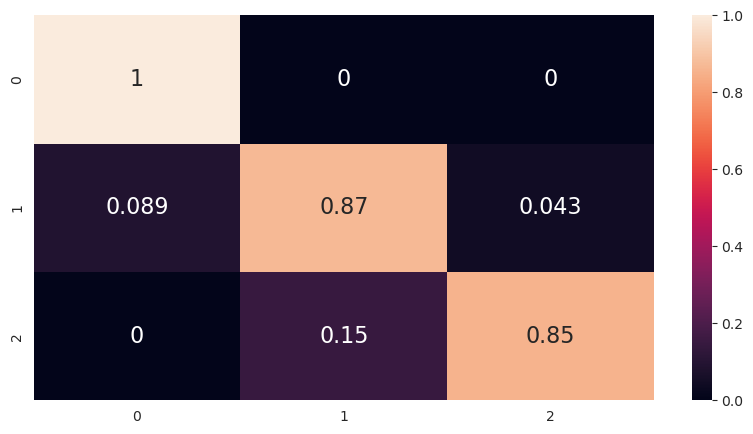

In [23]:
trainer.test(datamodule=data_module, ckpt_path='last')

### 5. Ważona entropia krzyżowa, aktywacja 3x sigmoid + 2x ReLU


In [24]:
mixed_centropy_weighted_model = ApartmentClassifier(input_size=len(features.columns), output_size=3, activations=3 * [nn.functional.sigmoid] + 2 * [nn.functional.relu], loss=torch.nn.CrossEntropyLoss(weight=torch.Tensor([2.8, 1.1, 2.5]), reduction='sum'))
logger = pl.loggers.TensorBoardLogger(
                save_dir='.',
                version='5_mixed_centropy_weighted_model',
                name='lightning_logs',
                log_graph=True
            )
trainer = pl.Trainer(max_epochs=300, enable_progress_bar=ENABLE_PROGRESS_BAR, logger=logger)
trainer.fit(mixed_centropy_weighted_model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/tomek/miniconda3/envs/ssne_p2/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory ./lightning_logs/5_mixed_centropy_weighted_model/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type               | Params | In sizes  | Out sizes
------------------------------------------------------------------------------------
0  | l1                  | Linear             | 17.4 K | [16, 33]  | [16, 512]
1  | l2                  | Linear             | 262 K  | [16, 512] | [16, 512]
2  | l3                  | Linear             | 131 K  | [16, 512] | [16, 256]
3  | l4                  | Linear             | 32.9 K | [16, 256] | [16, 128]
4  | l5   

/home/tomek/miniconda3/envs/ssne_p2/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:189: UserWarning: .test(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_acc_0         │     0.931034505367279     │
│        test_acc_1         │     0.775086522102356     │
│        test_acc_2         │     0.892307698726654     │
│         test_loss         │     0.550877571105957     │
│       test_mean_acc       │    0.8155339956283569     │
│ test_mean_acc_unweighted  │    0.8661429087320963     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.550877571105957,
  'test_mean_acc': 0.8155339956283569,
  'test_acc_0': 0.931034505367279,
  'test_acc_1': 0.775086522102356,
  'test_acc_2': 0.892307698726654,
  'test_mean_acc_unweighted': 0.8661429087320963}]

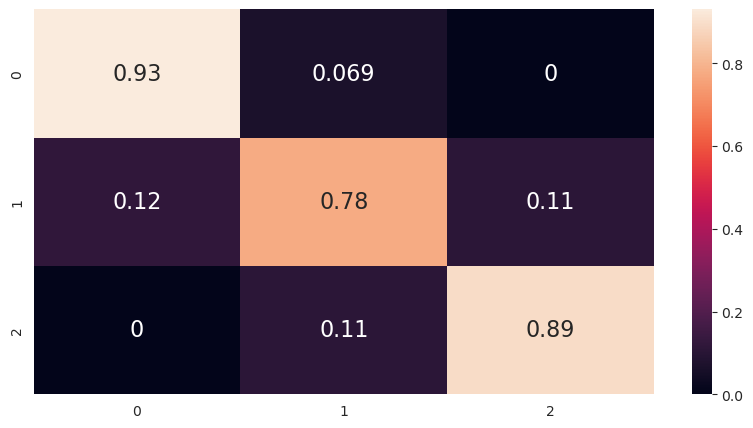

In [25]:
trainer.test(datamodule=data_module, ckpt_path='last')

### 6. Ważona entropia krzyżowa, aktywacja 3x sigmoid + 2x ReLU, normalizacja pakietowa


In [26]:
mixed_centropy_weighted_batchnorm_model = ApartmentClassifier(input_size=len(features.columns), output_size=3, activations=3 * [nn.functional.sigmoid] + 2 * [nn.functional.relu], loss=torch.nn.CrossEntropyLoss(weight=torch.Tensor([2, 1, 2.5]), reduction='sum'),batch_norm=True)
logger = pl.loggers.TensorBoardLogger(
                save_dir='.',
                version='6_mixed_centropy_weighted_batchnorm_model',
                name='lightning_logs',
                log_graph=True
            )
trainer = pl.Trainer(max_epochs=300, enable_progress_bar=ENABLE_PROGRESS_BAR, logger=logger)
trainer.fit(mixed_centropy_weighted_batchnorm_model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/tomek/miniconda3/envs/ssne_p2/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory ./lightning_logs/6_mixed_centropy_weighted_batchnorm_model/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type               | Params | In sizes  | Out sizes
------------------------------------------------------------------------------------
0  | l1                  | Linear             | 17.4 K | [16, 33]  | [16, 512]
1  | l2                  | Linear             | 262 K  | [16, 512] | [16, 512]
2  | l3                  | Linear             | 131 K  | [16, 512] | [16, 256]
3  | l4                  | Linear             | 32.9 K | [16, 256] | [16, 128]


/home/tomek/miniconda3/envs/ssne_p2/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:189: UserWarning: .test(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_acc_0         │            1.0            │
│        test_acc_1         │    0.8802816867828369     │
│        test_acc_2         │         0.921875          │
│         test_loss         │    0.29714658856391907    │
│       test_mean_acc       │     0.905339777469635     │
│ test_mean_acc_unweighted  │    0.9340522289276123     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.29714658856391907,
  'test_mean_acc': 0.905339777469635,
  'test_acc_1': 0.8802816867828369,
  'test_acc_0': 1.0,
  'test_acc_2': 0.921875,
  'test_mean_acc_unweighted': 0.9340522289276123}]

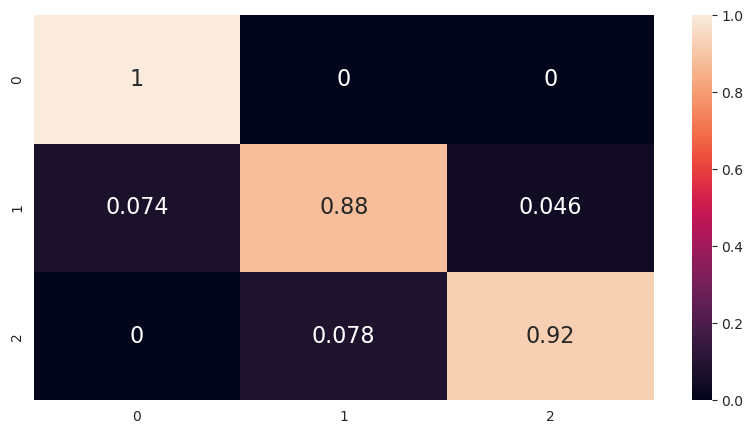

In [27]:
trainer.test(datamodule=data_module, ckpt_path='last')

### 7. Ważona entropia krzyżowa, aktywacja ReLU, normalizacja pakietowa


In [37]:
relu_centropy_weighted_batchnorm_model = ApartmentClassifier(input_size=len(features.columns), output_size=3, activations=nn.functional.relu, loss=torch.nn.CrossEntropyLoss(weight=torch.Tensor([2.5, 1.1, 2.2]), reduction='sum'),batch_norm=True)
logger = pl.loggers.TensorBoardLogger(
                save_dir='.',
                version='7_relu_centropy_weighted_batchnorm_model',
                name='lightning_logs',
                log_graph=True
            )
trainer = pl.Trainer(max_epochs=300, enable_progress_bar=ENABLE_PROGRESS_BAR, logger=logger)
trainer.fit(relu_centropy_weighted_batchnorm_model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type               | Params | In sizes  | Out sizes
------------------------------------------------------------------------------------
0  | l1                  | Linear             | 17.4 K | [16, 33]  | [16, 512]
1  | l2                  | Linear             | 262 K  | [16, 512] | [16, 512]
2  | l3                  | Linear             | 131 K  | [16, 512] | [16, 256]
3  | l4                  | Linear             | 32.9 K | [16, 256] | [16, 128]
4  | l5                  | Linear             | 4.1 K  | [16, 128] | [16, 32] 
5  | l6                  | Linear             | 99     | [16, 32]  | [16, 3]  
6  | _loss               | CrossEntropyLoss   | 0      | ?         | ?        
7  | bn1                 | BatchNorm1d        | 1.0 K  | [16, 512] | [16, 512]
8  | bn2 

/home/tomek/miniconda3/envs/ssne_p2/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:189: UserWarning: .test(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_acc_0         │         0.953125          │
│        test_acc_1         │    0.8105263113975525     │
│        test_acc_2         │    0.8253968358039856     │
│         test_loss         │     0.415191650390625     │
│       test_mean_acc       │    0.8349514603614807     │
│ test_mean_acc_unweighted  │    0.8630160490671793     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.415191650390625,
  'test_mean_acc': 0.8349514603614807,
  'test_acc_1': 0.8105263113975525,
  'test_acc_0': 0.953125,
  'test_acc_2': 0.8253968358039856,
  'test_mean_acc_unweighted': 0.8630160490671793}]

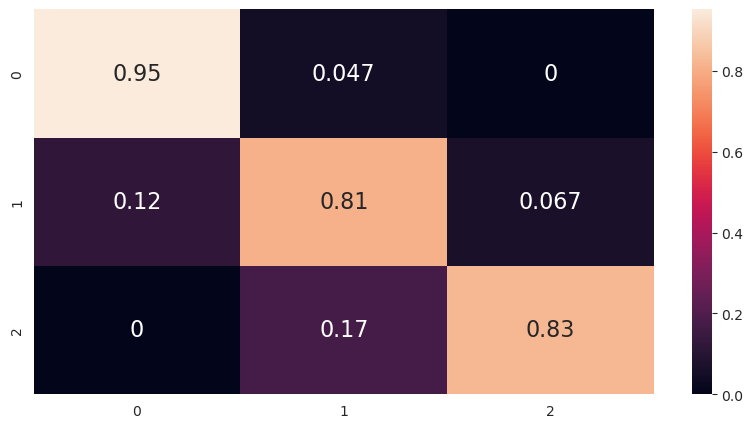

In [38]:
trainer.test(datamodule=data_module, ckpt_path='last')

# Predykcje na zbiorze testowym

In [50]:
TEST_DATA = Path('data/test_data.csv')

_test_df = pd.read_csv(TEST_DATA)
_test_df

,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,1993,914,10,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,20.0,Myung-duk,4,14.0,17.0
1,2014,907,16,terraced,individual_heating,management_in_trust,90.0,1174.0,0~5min,0-5min,7.0,20.0,Myung-duk,9,14.0,17.0
2,2007,1629,7,terraced,individual_heating,management_in_trust,7.0,605.0,0~5min,0-5min,5.0,5.0,Banwoldang,5,9.0,5.0
3,2005,743,21,mixed,individual_heating,management_in_trust,67.0,798.0,0~5min,5min~10min,6.0,0.0,Bangoge,7,13.0,15.0
4,2006,903,7,terraced,individual_heating,management_in_trust,123.0,181.0,5min~10min,0-5min,3.0,11.0,Myung-duk,4,8.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762,2006,2056,2,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
1763,2007,1394,7,terraced,individual_heating,management_in_trust,554.0,524.0,0~5min,0-5min,5.0,10.0,Banwoldang,4,9.0,8.0
1764,1993,644,20,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,20.0,Myung-duk,4,14.0,17.0
1765,2008,914,11,terraced,individual_heating,management_in_trust,197.0,475.0,5min~10min,0-5min,6.0,14.0,Sin-nam,8,7.0,9.0


In [51]:
scale, inverse_scale = create_scaler_pair(_test_df)

_df_test_scaled = scale(_test_df)
_df_test_scaled

,AptManageType,Floor,HallwayType,HeatingType,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_Parkinglot(Basement),N_Parkinglot(Ground),N_SchoolNearBy(Total),N_elevators,N_manager,Size(sqf),SubwayStation,TimeToBusStop,TimeToSubway,YearBuilt
0,management_in_trust,0.219512,mixed,individual_heating,0.333333,0.8750,0.405753,0.733520,1.000000,0.740741,0.538462,0.353769,Myung-duk,0~5min,15min~20min,0.405405
1,management_in_trust,0.365854,terraced,individual_heating,0.888889,0.8750,0.888721,0.126227,1.000000,0.740741,0.461538,0.350590,Myung-duk,0~5min,0-5min,0.972973
2,management_in_trust,0.146341,terraced,individual_heating,0.444444,0.5625,0.457986,0.009818,0.294118,0.185185,0.307692,0.678474,Banwoldang,0~5min,0-5min,0.783784
3,management_in_trust,0.487805,mixed,individual_heating,0.666667,0.8125,0.604088,0.093969,0.882353,0.000000,0.384615,0.276113,Bangoge,0~5min,5min~10min,0.729730
4,management_in_trust,0.146341,terraced,individual_heating,0.333333,0.5000,0.137017,0.172511,0.647059,0.407407,0.153846,0.348774,Myung-duk,5min~10min,0-5min,0.756757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762,management_in_trust,0.024390,terraced,individual_heating,0.444444,0.1875,0.405753,0.349229,0.411765,0.407407,0.307692,0.872389,Sin-nam,0~5min,0-5min,0.756757
1763,management_in_trust,0.146341,terraced,individual_heating,0.333333,0.5625,0.396669,0.776999,0.470588,0.370370,0.307692,0.571753,Banwoldang,0~5min,0-5min,0.783784
1764,management_in_trust,0.463415,mixed,individual_heating,0.333333,0.8750,0.405753,0.733520,1.000000,0.740741,0.538462,0.231153,Myung-duk,0~5min,15min~20min,0.405405
1765,management_in_trust,0.243902,terraced,individual_heating,0.777778,0.4375,0.359576,0.276297,0.529412,0.518519,0.384615,0.353769,Sin-nam,5min~10min,0-5min,0.810811


In [52]:
test_features = pd.concat([_df_test_scaled.drop(columns=categorical_cols),
                *[pd.get_dummies(_df_test_scaled[col], prefix=col, dtype=int) for col in categorical_cols]], axis=1)
test_features

,Floor,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_Parkinglot(Basement),N_Parkinglot(Ground),N_SchoolNearBy(Total),N_elevators,N_manager,Size(sqf),YearBuilt,...,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,0.219512,0.333333,0.8750,0.405753,0.733520,1.000000,0.740741,0.538462,0.353769,0.405405,...,0,0,0,0,0,0,0,1,0,0
1,0.365854,0.888889,0.8750,0.888721,0.126227,1.000000,0.740741,0.461538,0.350590,0.972973,...,0,0,0,0,0,0,0,1,0,0
2,0.146341,0.444444,0.5625,0.457986,0.009818,0.294118,0.185185,0.307692,0.678474,0.783784,...,0,0,0,1,0,0,0,0,0,0
3,0.487805,0.666667,0.8125,0.604088,0.093969,0.882353,0.000000,0.384615,0.276113,0.729730,...,1,0,1,0,0,0,0,0,0,0
4,0.146341,0.333333,0.5000,0.137017,0.172511,0.647059,0.407407,0.153846,0.348774,0.756757,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762,0.024390,0.444444,0.1875,0.405753,0.349229,0.411765,0.407407,0.307692,0.872389,0.756757,...,0,0,0,0,0,0,0,0,1,0
1763,0.146341,0.333333,0.5625,0.396669,0.776999,0.470588,0.370370,0.307692,0.571753,0.783784,...,0,0,0,1,0,0,0,0,0,0
1764,0.463415,0.333333,0.8750,0.405753,0.733520,1.000000,0.740741,0.538462,0.231153,0.405405,...,0,0,0,0,0,0,0,1,0,0
1765,0.243902,0.777778,0.4375,0.359576,0.276297,0.529412,0.518519,0.384615,0.353769,0.810811,...,0,0,0,0,0,0,0,0,1,0


In [53]:
# sanity check - ensure column ordering is correct 
assert _df_scaled.columns.tolist() == _df_test_scaled.columns.tolist()  # before encoding
assert features.columns.tolist() == test_features.columns.tolist()  # after encoding

In [54]:
cats = [
    _df_scaled[col].astype('category').dtype.categories.tolist() for col in categorical_cols
]
t_cats = [
    _df_test_scaled[col].astype('category').dtype.categories.tolist() for col in categorical_cols
]

# sanity check - ensure categories in train and test dataset are matching (pandas will use the same one-hot encoding)
assert cats == t_cats

In [55]:
# sanity check - ensure all categorical attrs were encoded the same way
for col, vals in zip(categorical_cols, cats):
    concat_train = pd.concat([_df[col], features[[c for c in features.columns if c.startswith(col)]]], axis=1)
    concat_test = pd.concat([_test_df[col], test_features[[c for c in features.columns if c.startswith(col)]]], axis=1)
    for val in vals:
        assert concat_train[concat_train[col] == val].head(n=1).values.tolist() == concat_test[concat_test[col] == val].head(n=1).values.tolist()

In [56]:
# re-using the entire dataset, since the previous train/val/test split happens in DataModule
train_dataloader = DataLoader(dataset, batch_size=512, shuffle=True, num_workers=4)

# use empty labels, since we are using the dataset only for testing
test_dataset = ApartmentDataset(features=test_features.values, labels=pd.DataFrame(False, index=range(len(test_features)), columns=[0, 1, 2]).values)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [57]:
final_model = ApartmentClassifier(input_size=len(features.columns), output_size=3, activations=3 * [nn.functional.sigmoid] + 2 * [nn.functional.relu], loss=torch.nn.CrossEntropyLoss(weight=torch.Tensor([2, 1, 2.5]), reduction='sum'),batch_norm=True)
logger = pl.loggers.TensorBoardLogger(
                save_dir='.',
                version='final_model',
                name='lightning_logs',
                log_graph=True
            )
trainer = pl.Trainer(max_epochs=300, enable_progress_bar=ENABLE_PROGRESS_BAR, logger=logger)
trainer.fit(final_model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/tomek/miniconda3/envs/ssne_p2/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory ./lightning_logs/final_model/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type               | Params | In sizes  | Out sizes
------------------------------------------------------------------------------------
0  | l1                  | Linear             | 17.4 K | [16, 33]  | [16, 512]
1  | l2                  | Linear             | 262 K  | [16, 512] | [16, 512]
2  | l3                  | Linear             | 131 K  | [16, 512] | [16, 256]
3  | l4                  | Linear             | 32.9 K | [16, 256] | [16, 128]
4  | l5                  | Lin

In [58]:
final_model.eval()
preds = pd.Series([int(final_model(x).argmax(axis=1)[0]) for x, _ in test_dataloader])
preds.to_csv('piatek_owienko_schafer_preds.csv', header=None, index=None)
print(preds)

0       1
1       2
2       2
3       1
4       1
       ..
1762    2
1763    1
1764    1
1765    1
1766    1
Length: 1767, dtype: int64


In [59]:
%load_ext tensorboard
%tensorboard --logdir=lightning_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...